In [43]:
pip install pybit

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 51.0/51.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pybit: filename=pybit-5.3.0-py2.py3-none-any.whl size=48474 sha256=aca016eaf65dc66f95942d2b3fab1bb36532ea166bb6be80e782dc9d6a62e1ba
  Stored in directory: c:\users\alter\appdata\local\pip\cache\wheels\3b\06\d0\c4901c6f3dece713778f1d482cb7b9e4023e476d92d78d1557
Successfully built pybit
Note: you may need to restart the kernel to use updated packages.


In [67]:
import pandas as pd
from pybit.unified_trading import HTTP, WebSocket
import numpy as np
import ssl  # To may use unverified SSL
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import sleep, time

In [68]:
# Url of site where we can download csv history data for free
URL = "https://www.cryptodatadownload.com/cdd/Binance_{symbol}USDT_d.csv"
FILENAME = 'Binance_{symbol}USDT_d.csv'

def get_historical_data(symbol: str = "BTC") -> pd.DataFrame:
    try:
        file = FILENAME.format(symbol=symbol)
        df = pd.read_csv(file, delimiter=",", skiprows=[0], header=0, parse_dates=[1])
    except FileNotFoundError:
        url = URL.format(symbol=symbol)
        df = pd.read_csv(url, delimiter=",", skiprows=[0], header=0, parse_dates=[1])
        # We delete the columns we don't need. Using of date is possible
        # (e.x. increasing weights for last time) but for now we leave this idea
    df.set_index(['Date'], inplace=True)
    return df.drop(['Unix', 'Symbol'], axis=1, inplace=False)


In [69]:
session = HTTP(
    testnet=False,
    api_key='eG0oUfh9Kc05PAZp55',
    api_secret='aGaVGQxhc6sEbTXfSOeBBLufs9gVu2qSBre5',
)


def get_kline_data(coin: str = "BTC") -> pd.DataFrame:
    symbol = coin + "USDT"
    kline_data = session.get_kline(
        category="linear",
        symbol=symbol,
        interval=15,
        limit=200
    )["result"]

    klines = np.array(kline_data['list'])
    df = pd.DataFrame(klines[:, [0, 1, 2, 3, 4, 5, 6]],
                      columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'])
    df.set_index('Time', inplace=True)

    # Transrofm values to numeric
    for col in ('Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'):
        df[col] = df[col].astype(float)
    return df


def get_last_prices() -> tuple:
    """
    Функция для извлечения последней цены ETH и BTC.
    Для минимальной задержки можно использовать вебсокет, но в
    данной задаче нам будет достаточно http-соединения
    (а ещё это намного удобнее)
    """

    btc_close_price = session.get_kline(
        category="linear",
        symbol='BTCUSDT',
        interval=1,
        limit=1
    )["result"]['list'][0][4]
    eth_close_price = session.get_kline(
        category="linear",
        symbol='ETHUSDT',
        interval=1,
        limit=1
    )["result"]['list'][0][4]
    return float(btc_close_price), float(eth_close_price)


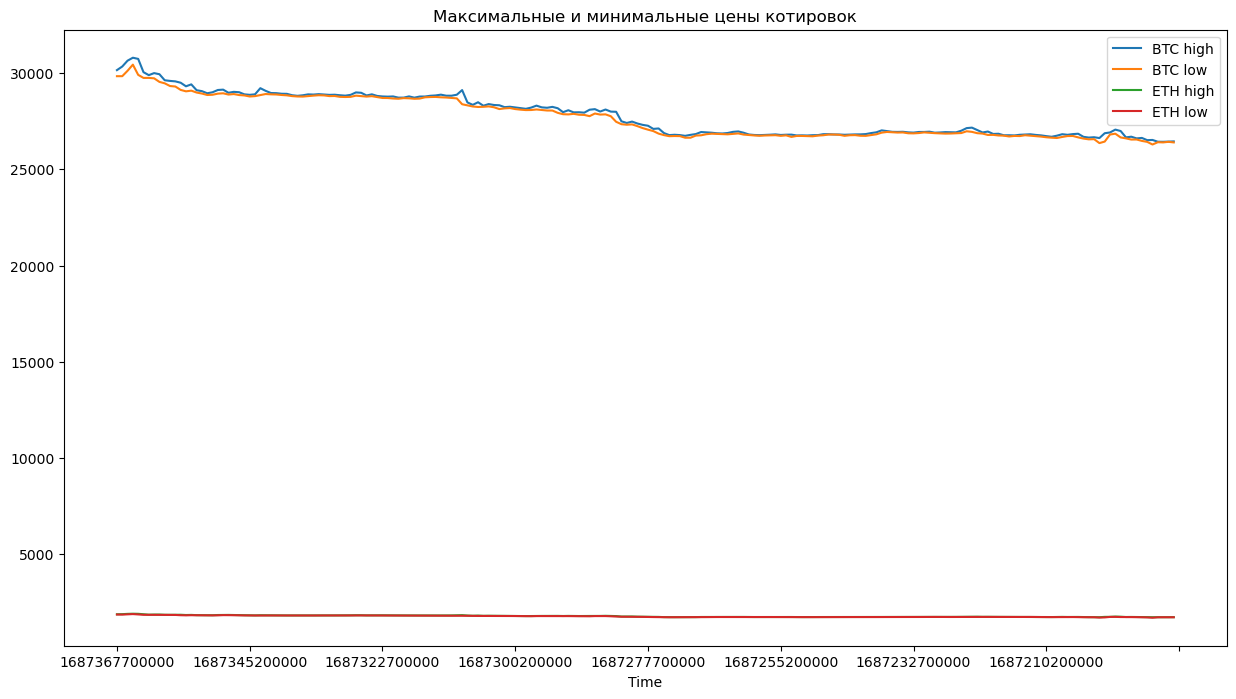

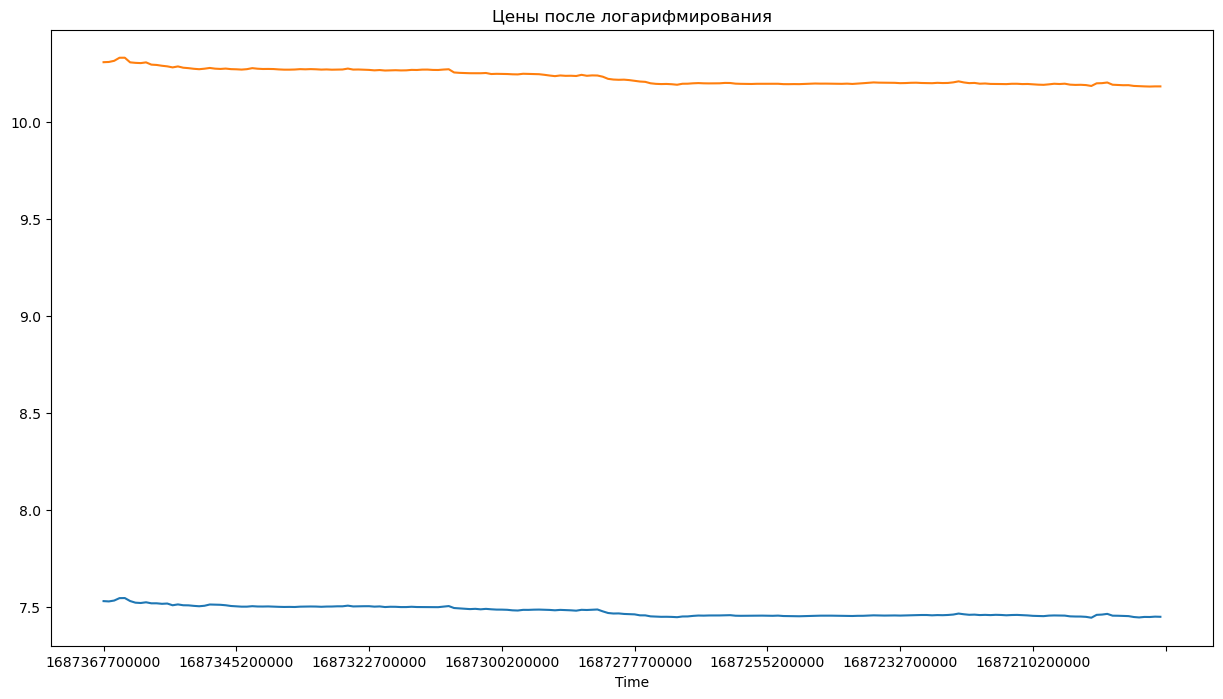

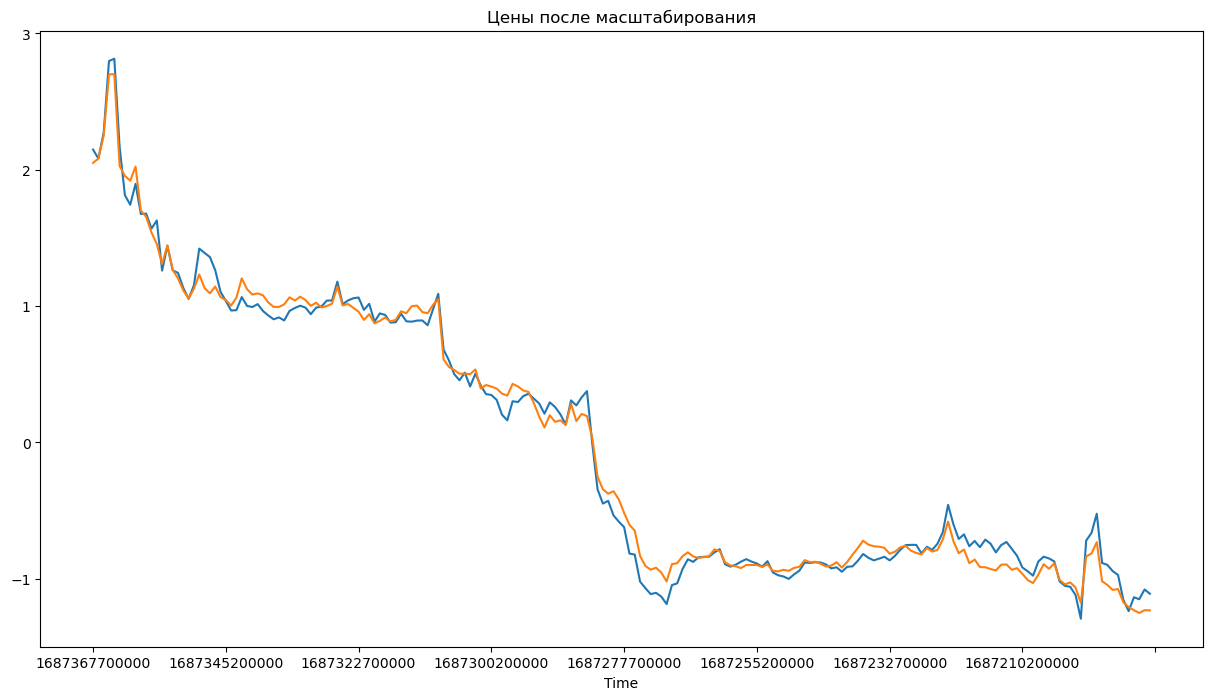

In [70]:
# Последние данные с биржи
eth_df = get_kline_data("ETH")
btc_df = get_kline_data()
btc_columns = ['High', 'Open', 'Close', 'Low', 'Volume', 'Turnover']


# Исторические данные за несколько лет (второй вариант)
# eth_df = get_historical_data("ETH")
# btc_df = get_historical_data()
# btc_columns = ['High', 'Open', 'Close', 'Low', 'Volume BTC', 'Volume USDT', 'tradecount']

# Посмотрим на графики цен
fig, ax = plt.subplots(figsize=(15, 8))
btc_df[['High','Low']].plot(ax=ax,)
eth_df[['High','Low']].plot(ax=ax)
ax.legend(['BTC high', 'BTC low', "ETH high", "ETH low"])
plt.title('Максимальные и минимальные цены котировок')
plt.show()
#Видно, что Eth "следует" за BTC, однако оценить влияние BTC сложно


# Посмотрим на логарифмы цен
fig, ax = plt.subplots(figsize=(15, 8))
btc_df['LnClose'] = np.log(btc_df['Close'])
eth_df['LnClose'] = np.log(eth_df['Close'])
# Посмотрим, что получилось
eth_df.LnClose.plot()
btc_df.LnClose.plot()
plt.title('Цены после логарифмирования')
plt.show()
# Видим, что цены очень сильно коррелируют.


# Произведём z-масштабирование признаков (логарифмы здесь не
# нужны - результат будет тем же после стандартизации)
for df in (btc_df, eth_df):
    # for price_type in ('LnOpen', 'LnClose',"LnHigh", "LnLow"):
    for price_type in ('Open', 'Close', "High", "Low"):
        df[price_type] = (df[price_type] - df[price_type].mean()) / df[price_type].std()

fig, ax = plt.subplots(figsize=(15, 8))
eth_df.Close.plot()
btc_df.Close.plot()
plt.title('Цены после масштабирования')
plt.show()
# Теперь данные хорошо "ложатся" друг на друга, между графиками
# видна чёткая корреляция


Correlation:  Close    0.995405
dtype: float64
Результат работы регрессионной модели:
                             OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3826.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          1.13e-197
Time:                        20:26:29   Log-Likelihood:                 195.41
No. Observations:                 200   AIC:                            -376.8
Df Residuals:                     193   BIC:                            -353.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

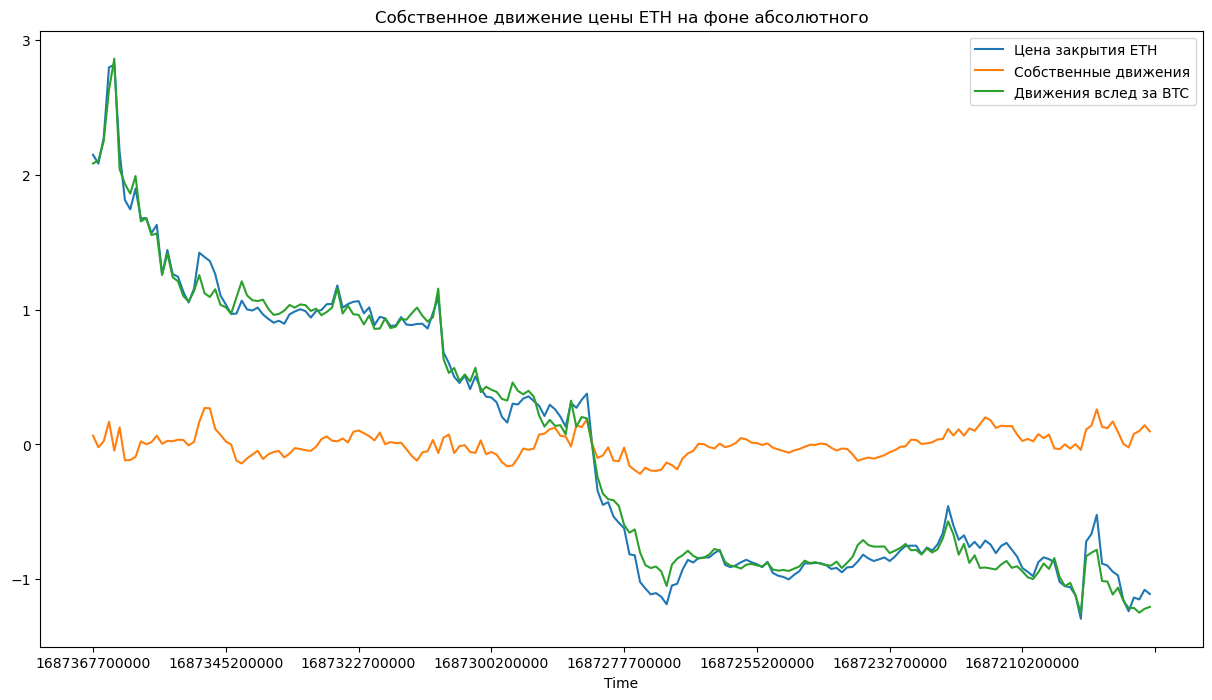

In [71]:
# Рассчитаем коэффициент корреляции между ценами ETH и BTC
correlation = eth_df[['Close']].corrwith(btc_df['Close'], axis=0)
print('Correlation: ', correlation)


# Строим парную регрессионную модель
ols = sm.OLS(eth_df[['Close']], sm.add_constant(btc_df[btc_columns])).fit()

from statsmodels.iolib.summary2 import Summary
result: Summary = ols.summary()
print("Результат работы регрессионной модели:\n", result)

coint_t, pvalue, crit_value = sm.tsa.stattools.coint(btc_df[['Close']], eth_df[['Close']])
print(f'coint_t: {coint_t}\n'
      f'pvalue (вероятность соблюдения нулевой гипотезы): {pvalue}\n'
      f'crit_value (пределы статистически значимой коинтеграции: {crit_value}')

# Коэффициент влияния BTC на цену ETH
btc_impact_ratio = ols.params['Close']
print('Коэффициент влияния BTC на цену ETH: ', btc_impact_ratio)


# Определим собственные движения цены с помощью регрессии
model = sm.OLS(eth_df['Close'], sm.add_constant(btc_df[btc_columns] * btc_impact_ratio)).fit()
btc_impact_price = model.predict(sm.add_constant(btc_df[btc_columns] * btc_impact_ratio))
eth_df['IM'] = eth_df['Close'] - btc_impact_price  # Idiosyncratic Movements


# Покажем движение цены на графике
fig, ax = plt.subplots(figsize=(15, 8))
eth_df.Close.plot(ax=ax)
eth_df.IM.plot(ax=ax)
plt.plot(btc_impact_price)
plt.title('Собственное движение цены ETH на фоне абсолютного')
ax.legend(['Цена закрытия ETH', 'Собственные движения', "Движения вслед за BTC"])
plt.show()


In [72]:
RANGE = 0.01  # 1%
PERIOD = 60 * 60  # 1 Hour


def send_notification(period, real_change, independent_change):
    print(
        f'Активное движение ETH за последние {period/60} минут!\n'
        f'Абсолютное изменение цены: {real_change}%\n'
        f'Собственное движение цены: {independent_change}%'
    )


class PriceHandler():
    def __init__(self):
        self.start_time = time()
        self.last_btc_price = None
        self.last_eth_price = None
        self.max = None
        self.min = None
        self.deviation = 0  # Отклонение от точки отсчёта
        self.true_deviation = 0

    def handle_prices(self, btc_price, eth_price):
        """
        Last price handling
        """

        if all((self.last_btc_price, self.last_eth_price)):
            # Изменения цены (в долларах)
            btc_delta = (btc_price - self.last_btc_price)
            eth_delta = (eth_price - self.last_eth_price)
            eth_IM_delta = eth_delta - btc_delta * btc_impact_ratio # Independent changes

            # Относительные изменения (дроби)
            eth_whole_change = eth_delta / self.last_eth_price
            eth_independent_change = eth_IM_delta / self.last_eth_price
            self.deviation += eth_whole_change  # Абсолютное движение
            self.true_deviation += eth_independent_change  # Независимое движение

            now = time()
            time_passed = now - self.start_time

            if time_passed > PERIOD or abs(self.deviation) > RANGE:

                if abs(self.deviation) > RANGE:
                    # Отправляем уведомление
                    send_notification(
                        PERIOD,
                        self.deviation * 100, self.true_deviation * 100
                    )

                # Сбрасываем время и отклонение цены
                self.start_time = now
                self.deviation = 0
                self.true_deviation = 0

        self.last_btc_price = btc_price
        self.last_eth_price = eth_price


client = PriceHandler()
count = 5

if __name__ == '__main__':
    print("\nОтслеживание цены запущено!")
    while count != 0:
        sleep(3)
        btc_last_price, eth_last_price = get_last_prices()
        print('Последняя цена ETH: ', eth_last_price)
        client.handle_prices(btc_last_price, eth_last_price)
        count-=1


Отслеживание цены запущено!
Последняя цена ETH:  1864.23
Последняя цена ETH:  1864.23
Последняя цена ETH:  1863.96
Последняя цена ETH:  1863.29
Последняя цена ETH:  1863.91
Последняя цена ETH:  1864.16
Последняя цена ETH:  1864.12
Последняя цена ETH:  1864.58
Последняя цена ETH:  1864.59
Последняя цена ETH:  1865.28
